# Multi-harmonic response example {#ref_basic_harmonic}

This example shows how to compute a multi-harmonic response using `fft`
transformations.


In [1]:
import matplotlib.pyplot as pyplot

from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

Begin by downloading the example harmonic result. This result is not
included in the core module by default to speed up the install. Download
should only take a few seconds.

Next, create the model and display the state of the result. This
harmonic result file contains several RPMs, and each RPM has several
frequencies.


In [2]:
# The size of this file is 66 MB. Downloading it might take some time.
harmonic = examples.download_multi_harmonic_result()
model = dpf.Model(harmonic)
print(model)

DPF Model
------------------------------
Harmonic analysis
Unit system: MKS: m, kg, N, s, V, A, degC
Physics Type: Mechanical
Available results:
     -  displacement: Nodal Displacement
     -  structural_temperature: ElementalNodal Temperature
------------------------------
DPF  Meshed Region: 
  88 nodes 
  31 elements 
  Unit: m 
  With beam (1D) elements
------------------------------
DPF  Time/Freq Support: 
  Number of sets: 1000 
  With complex values 

Cumulative     Frequency (Hz) LoadStep       Substep        RPM             
1              1.000000       1              1              100.000000      
2              2.000000       1              2              100.000000      
3              3.000000       1              3              100.000000      
4              4.000000       1              4              100.000000      
5              5.000000       1              5              100.000000      
6              6.000000       1              6              100.000000   

Read the analysis domain support


In [3]:
tf = model.metadata.time_freq_support
print("Number of solution sets", tf.n_sets)

Number of solution sets 1000


# Compute multi-harmonic response

This example computes the Rz multi-harmonic responses based on selected
nodes and a set of EOs (engine orders).


In [4]:
# Create a total displacement operator and set its time scoping to
# the entire time frequency support and its nodes scoping to user-defined nodes.
disp_op = ops.result.raw_displacement(data_sources=model)
time_ids = list(range(1, model.metadata.time_freq_support.n_sets + 1))

# Define nodal scoping
nodes = dpf.Scoping()
nodes.ids = [2, 18]

# Connect the frequencies and the nodes scopings to the result
# provider operator.
disp_op.inputs.mesh_scoping.connect(nodes)
disp_op.inputs.time_scoping.connect(time_ids)

# Extract the Rz component using the component selector operator.
comp = dpf.Operator("component_selector_fc")
comp.inputs.connect(disp_op.outputs)
comp.inputs.component_number.connect(5)

# Compute the multi-harmonic response based on Rz and a set of RPMs.
rpms = dpf.Scoping()
rpms.ids = [1, 2, 3]

fft = ops.math.fft_multi_harmonic_minmax()

fft.inputs.connect(comp.outputs)
fft.inputs.rpm_scoping.connect(rpms)

fields = fft.outputs.field_max()
len(fields)  # one multi-harmonic field response per node

field1 = fields[0]
field2 = fields[1]

Plot the maximum displacements over time for Node ID 2 and 18


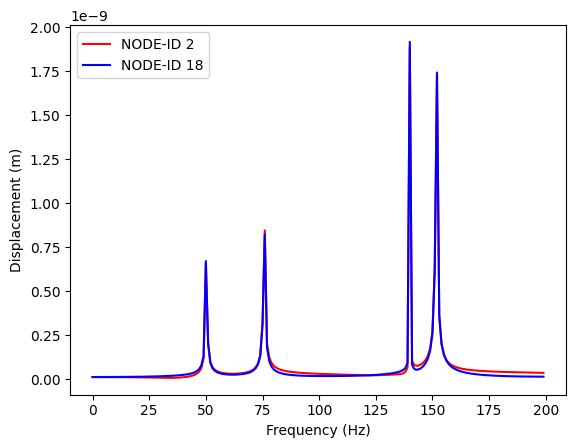

In [5]:
pyplot.plot(field1.data, "r", label="NODE-ID 2")
pyplot.plot(field2.data, "b", label="NODE-ID 18")
pyplot.xlabel("Frequency (Hz)")
pyplot.ylabel("Displacement (m)")
pyplot.legend()
pyplot.show()